<a href="https://colab.research.google.com/github/Zahab163/fake_news_detection_LSTM/blob/main/Fake_News_Detection_with_NLP(_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection with LSTM

## Objective
This notebook demonstrates fake news detection using a deep learning approach:
- Visualizing the the Data and WordCloud
- Preprocess text data (tokenization, padding).
- Build and train an LSTM model with embeddings and dropout.
- Apply EarlyStopping to prevent overfitting.
- Evaluate performance with accuracy, F1 score, confusion matrix, and ROC curve.
- Visualize training vs validation accuracy/loss curves.

In [1]:
pip install tensorflow

In [2]:
#  Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")



Importing the data path from kaggle to work on further

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fake-news-detection-datasets' dataset.
Path to dataset files: /kaggle/input/fake-news-detection-datasets


In [ ]:
There are two different .csv files so we are importing both of them

In [20]:
# 2. Load Dataset
fake = pd.read_csv("/kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv")
true = pd.read_csv("/kaggle/input/fake-news-detection-datasets/News _dataset/True.csv")




## Visualizing the data Before cleaning

Why are we exploring our data ??
- frist cause Fake and Authentic datasets are in different .csv file so we are visualizing our data ditribution seperately .
- second cause we are working on Binary Classification answer .True, False so, we will drop all the other columns and rows

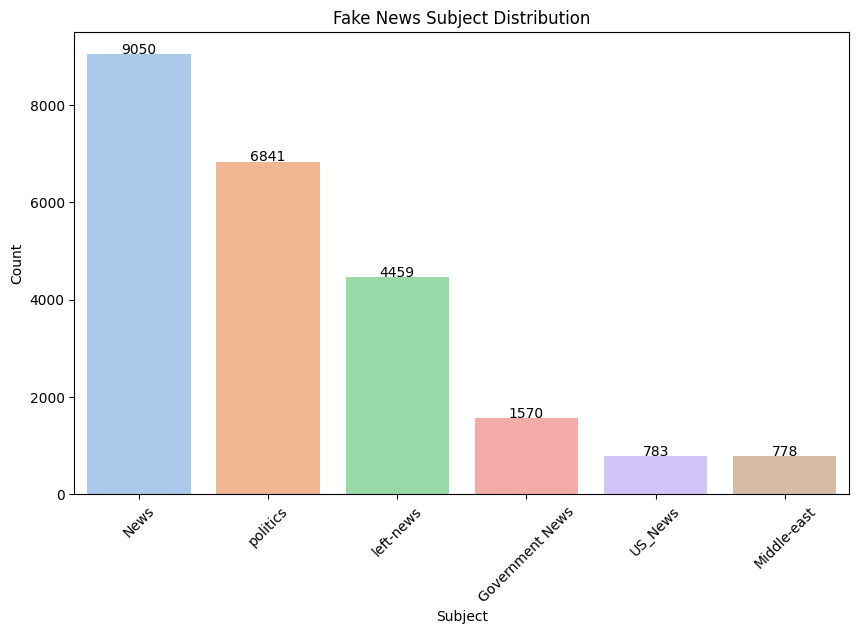

In [22]:
subject_counts = fake['subject'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=subject_counts.index, y=subject_counts.values, hue=subject_counts.index, palette=sns.color_palette('pastel', 6), legend=False)
plt.title('Fake News Subject Distribution')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)

for index, value in enumerate(subject_counts):
    plt.text(index, value + 10, str(value), ha='center' )


plt.show()

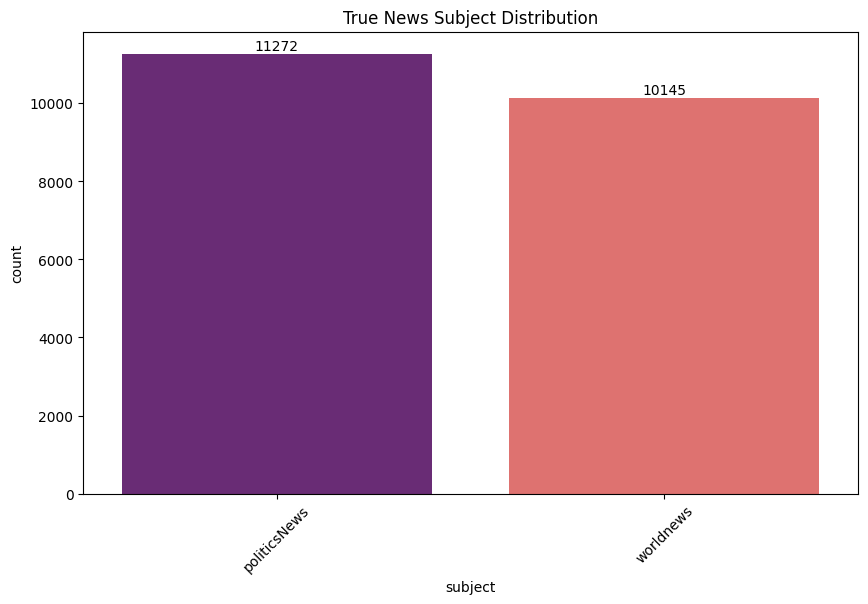

In [24]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=true, x='subject', hue='subject', palette='magma', legend=False)
plt.title('True News Subject Distribution')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
plt.show()

Now , just making word cloud for  checking the words used widely

In [26]:
#Importing wordcloud
from wordcloud import WordCloud

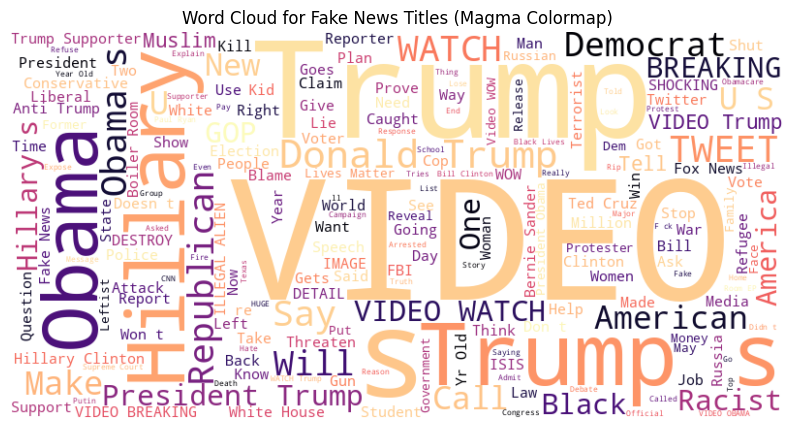

In [27]:
# Word cloud for fake news titles
fake_titles = ' '.join(fake['title'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(fake_titles)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Word Cloud for Fake News Titles (Magma Colormap)')
plt.axis('off')
plt.show()

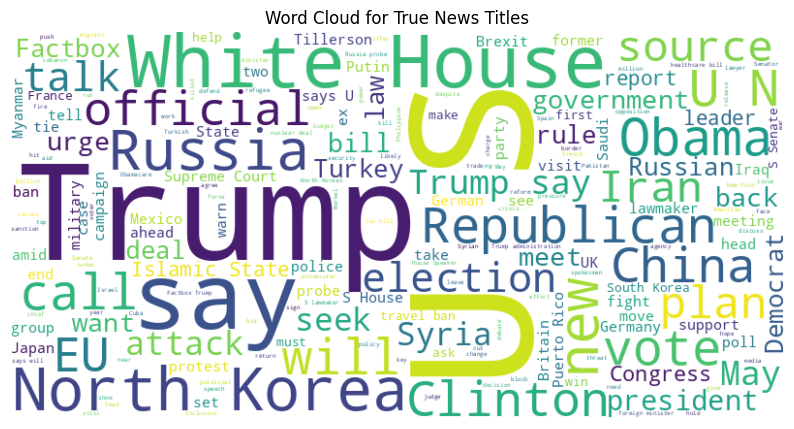

In [29]:
# Word cloud for true news titles
true_titles = ' '.join(true['title'])
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_titles)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.title('Word Cloud for True News Titles')
plt.axis('off')
plt.show()

## Cleaning and preparing data for NLP Modeling

In [31]:
## combining and labeling the data true and fake into one for smothly handlying the data
df = pd.concat([fake, true], axis=0).reset_index(drop=True)

#Labeling
fake['label'] = 0
true['label'] = 1



In [32]:
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [33]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [34]:
## dropping unnecessary columns or duplicates
df.drop(['subject', 'date', 'title'], axis=1, inplace=True, errors='ignore')
df.drop_duplicates(inplace=True)


we have dropped date too cause date is not used for classification(binary) model

In [35]:
 # Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [38]:
df.head()

,text,label
0,(This September 29 has been corrected to fix ...,1
1,(Reuters) - U.S. President Donald Trump said o...,1
2,PRISTINA (Reuters) - Kosovo s center-right coa...,1
3,WASHINGTON (Reuters) - President Donald Trump ...,1
4,A Pennsylvania man apparently failed basic bio...,0


Displaying the text for lenght check , only one item display .

In [39]:
df['text'][0]

' (This September 29 has been corrected to fix date of election in paragraph 3) NAIROBI (Reuters) - A Kenyan government watchdog said on Friday it was investigating whether police had assaulted students during protests this week at the University of Nairobi over the detention of an opposition lawmaker.   Police fired tear gas on Thursday at the protesting students. Video footage posted on social media later in the day showed uniformed officers outside dormitories and inside classrooms using batons to hit people who did not appear to be involved in the campus protests.  It was the latest crackdown by police on protests since an Aug. 8 presidential election that was later annulled by the Supreme Court. A re-run of the vote has been set for Oct. 26. The Independent Police Oversight Authority (IPOA)  this morning noted from social media reports of an incident in which members of the National Police Service allegedly stormed the University of Nairobi and assaulted students at the institutio

In [42]:
#importing re for working with regular expression
import re

In [43]:
# Remove special characters and punctuations
df['clean']= df['text'].apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', x))
# Convert to lowercase
df['clean'] = df['clean'].str.lower()
# Remove extra spaces
df['clean'] = df['clean'].apply(lambda x: re.sub(' +', ' ', x))

In [46]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['clean'] = df['clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [47]:
df.head()

,text,label,clean
0,(This September 29 has been corrected to fix ...,1,september 29 corrected fix date election parag...
1,(Reuters) - U.S. President Donald Trump said o...,1,reuters u president donald trump said friday a...
2,PRISTINA (Reuters) - Kosovo s center-right coa...,1,pristina reuters kosovo center right coalition...
3,WASHINGTON (Reuters) - President Donald Trump ...,1,washington reuters president donald trump frid...
4,A Pennsylvania man apparently failed basic bio...,0,pennsylvania man apparently failed basic biolo...


##Split Features and Labels

In [48]:
#labeling
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Tokenization & Padding

In [49]:
#  Tokenization & Padding
max_words = 10000
max_len = 300

tokenizer = Tokenizer(num_words=max_words, oov_token="<unk>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


##Building NLP(LSTM) Model:

In [50]:
#  Build LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    LSTM(128),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. Train with EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop]
)




Epoch 1/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 370s 755ms/step - accuracy: 0.8085 - loss: 0.4462 - val_accuracy: 0.8918 - val_loss: 0.4385
Epoch 2/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 371s 732ms/step - accuracy: 0.8829 - loss: 0.3100 - val_accuracy: 0.9737 - val_loss: 0.0898
Epoch 3/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 354s 731ms/step - accuracy: 0.9623 - loss: 0.1258 - val_accuracy: 0.9719 - val_loss: 0.1045
Epoch 4/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 417s 863ms/step - accuracy: 0.9569 - loss: 0.1308 - val_accuracy: 0.9749 - val_loss: 0.0936
Epoch 5/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 457s 946ms/step - accuracy: 0.9668 - loss: 0.1193 - val_accuracy: 0.9748 - val_loss: 0.1095


we have used early stopping to void overfitting and to get the best result

## Evaluation

In [51]:
# Evaluation
y_pred_lstm = (model.predict(X_test_pad) > 0.5).astype("int32")

print("LSTM Results")
print(classification_report(y_test, y_pred_lstm))


242/242 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step
LSTM Results
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3468
           1       0.97      0.98      0.98      4262

    accuracy                           0.97      7730
   macro avg       0.97      0.97      0.97      7730
weighted avg       0.97      0.97      0.97      7730



## Result's Visualization

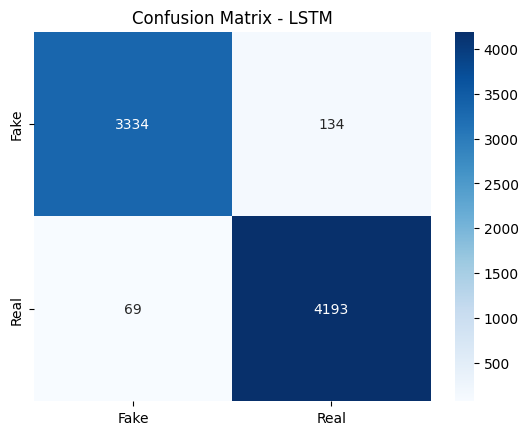

In [52]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.title("Confusion Matrix - LSTM")
plt.show()

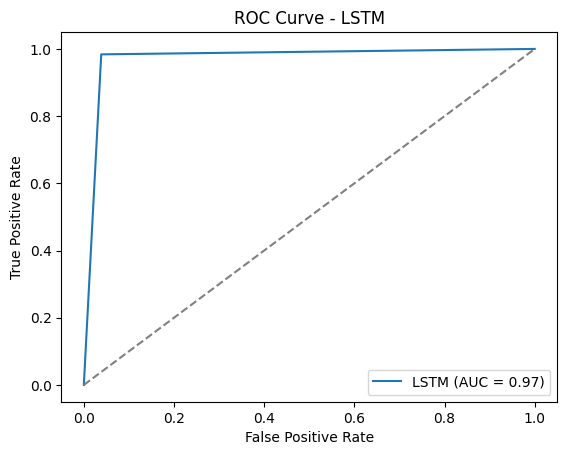

In [53]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'LSTM (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend()
plt.show()


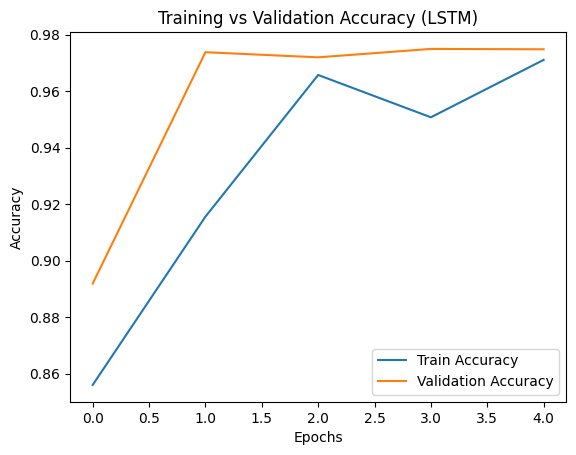

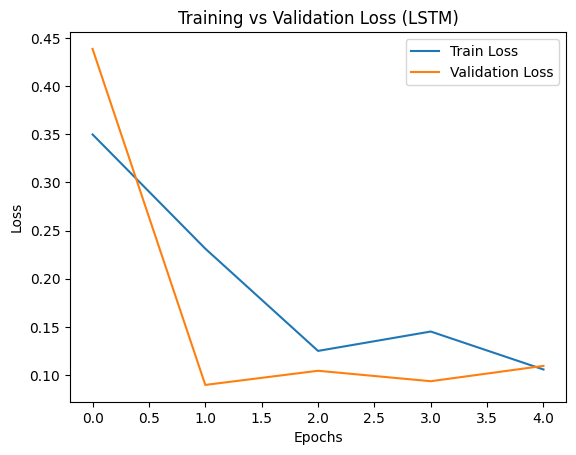

In [54]:
# Training vs Validation Accuracy/Loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy (LSTM)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss (LSTM)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Conclusion

In this notebook, we:
1. Prepared the dataset by merging fake and true news articles.
2. Tokenized and padded text sequences for deep learning.
3. Built and trained an LSTM model with embeddings, dropout, and EarlyStopping.
4. Evaluated performance using accuracy, F1 score, confusion matrix, and ROC curve.
5. Visualized training vs validation accuracy and loss.

**Key Insight:**  
The LSTM model effectively captures sequential word patterns, improving fake news detection beyond simple baselines. EarlyStopping ensured efficient training and prevented overfitting.